In [25]:
#x01_populationStatistics

In [26]:
from chewc.chewc import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [27]:
class MyNetwork(nn.Module):
    def __init__(self, L, P):
        super(MyNetwork, self).__init__()
        
        # Layers for input1 and input3
        self.fc1 = nn.Linear(L, 128)
        self.fc2 = nn.Linear(128, 64)
        
        # Layers for input2 and input4
        self.fc3 = nn.Linear(P, 128)
        self.fc4 = nn.Linear(128, 64)
        
        # Layers for the upper triangle of input_matrix
        self.fc_matrix = nn.Linear(L * (L + 1) // 2, 256)
        
        # Final fully connected layers
        self.fc_final1 = nn.Linear(64 * 4 + 256, 64)
        self.fc_final2 = nn.Linear(64, 10)  # Output 10 values (2 controls * 5 levels)
    
    def forward(self, input1, input2, input3, input4, input_matrix):
        
        # Process input1 and input3
        x1 = F.relu(self.fc1(input1))
        x1 = F.relu(self.fc2(x1))
        
        x3 = F.relu(self.fc1(input3))
        x3 = F.relu(self.fc2(x3))
        
        # Process input2 and input4
        x2 = F.relu(self.fc3(input2))
        x2 = F.relu(self.fc4(x2))
        
        x4 = F.relu(self.fc3(input4))
        x4 = F.relu(self.fc4(x4))
        
        # Process input_matrix
        indices = torch.triu_indices(input_matrix.size(1), input_matrix.size(2))
        upper_triangle = input_matrix[:, indices[0], indices[1]]
        x_matrix = F.relu(self.fc_matrix(upper_triangle))
        
        # Concatenate all features
        x = torch.cat((x1, x2, x3, x4, x_matrix), dim=1)
        
        # Final fully connected layers
        x = F.relu(self.fc_final1(x))
        output = self.fc_final2(x)
        
        # Reshape and apply softmax to get probabilities for each control's levels
        output = output.view(-1, 2, 5)  # Reshape to (batch_size, 2 controls, 5 levels)
        output = F.softmax(output, dim=2)  # Apply softmax along the levels dimension
        
        return output

In [44]:
#| export
#| export

def population_statistics(population_tensor):

    
    #Calculate the mean genotype value divided by 2 for each marker.
    def calculate_allele_frequencies(genotypes):
        num_individuals = genotypes.size(0)
        allele_frequencies = torch.mean(genotypes, dim=0) / 2.
        return allele_frequencies
    #Calculate the unique genotype counts and their frequencies.
    def calculate_genotype_frequencies(genotypes):
        num_individuals = genotypes.size(0)
        unique_genotypes, counts = torch.unique(genotypes, dim=0, return_counts=True)
        genotype_frequencies = counts.float() / num_individuals
        return unique_genotypes, genotype_frequencies
    #Calculate the proportion of heterozygous individuals at each marker.
    def calculate_heterozygosity(genotypes):
        num_individuals = genotypes.size(0)
        heterozygosity = torch.sum(genotypes == 1, dim=0).float() / num_individuals
        return heterozygosity
    #Calculate the frequency of the less common allele.
    def calculate_maf(genotypes):
        allele_frequencies = calculate_allele_frequencies(genotypes)
        maf = torch.minimum(allele_frequencies, 1 - allele_frequencies)
        return maf
    #Measure the degree of inbreeding based on observed and expected heterozygosity.
    def calculate_inbreeding_coefficient(genotypes):
        num_markers = genotypes.size(1)
        observed_heterozygosity = torch.sum(genotypes == 1, dim=1).float() / num_markers
        expected_heterozygosity = 2 * calculate_allele_frequencies(genotypes) * (1 - calculate_allele_frequencies(genotypes))
        average_expected_heterozygosity = torch.mean(expected_heterozygosity)
        inbreeding_coefficient = 1 - (observed_heterozygosity / average_expected_heterozygosity)
        return inbreeding_coefficient
    #Calculate the correlation matrix for the genotypes.
    def calculate_ld(genotypes):
        num_markers = genotypes.size(1)
        ld_matrix = torch.corrcoef(genotypes.T)
        return ld_matrix
    #Measure the genetic differentiation between subpopulations.
    def calculate_fst(genotypes, subpopulations):
        total_allele_frequencies = calculate_allele_frequencies(genotypes)
        subpop_allele_frequencies = [calculate_allele_frequencies(genotypes[subpop]) for subpop in subpopulations]
        ht = 2 * total_allele_frequencies * (1 - total_allele_frequencies)
        hs = torch.mean(torch.stack([2 * freq * (1 - freq) for freq in subpop_allele_frequencies]), dim=0)
        fst = (ht - hs) / ht
        return fst
    #Estimate the effective population size based on allele frequencies and genetic drift.
    def calculate_effective_population_size(genotypes):
        num_individuals = genotypes.size(0)
        allele_frequencies = calculate_allele_frequencies(genotypes)
        variance = torch.var(allele_frequencies)
        ne = (num_individuals - 1) / (2 * variance)
        return ne

    genotypes = population_tensor
    stats = {
        'allele_frequencies': calculate_allele_frequencies(genotypes),
        'genotype_frequencies': calculate_genotype_frequencies(genotypes),
        'heterozygosity': calculate_heterozygosity(genotypes),
        'maf': calculate_maf(genotypes),
        'inbreeding_coefficient': calculate_inbreeding_coefficient(genotypes),
        'ld_matrix': calculate_ld(genotypes),
        'effective_population_size': calculate_effective_population_size(genotypes)
    }
    return stats
class BreedingSimulation:
    def __init__(self, G, T, h2, reps, pop_size, selection_fraction):
        self.G = G
        self.T = T
        self.h2 = h2
        self.reps = reps
        self.pop_size = pop_size
        self.selection_fraction = selection_fraction
        self.population = create_pop(G, create_random_pop(G, pop_size)) # Start with a random population
        self.history = []  # For tracking population data over generations
        # Initialize phenotypes and breeding_values to zero tensors
        self.population.phenotypes = torch.zeros(pop_size) 
        self.population.breeding_values = torch.zeros(pop_size)
        
    def step(self, actions): # Actions will be provided by the RL agent
        selected_parent_indices = self.select_parents(actions)
        selected = self.population.haplotypes[selected_parent_indices]
        
        #breeding
        m = recombine(selected)  # Mother gametes
        f = recombine(selected)  # Father gametes
        progeny = create_progeny(m, f, reps=self.reps)  # Create progeny

        #phenotype
        self.population = update_pop(self.population, progeny)
        bv(self.population, self.T)
        phenotype(self.population, self.T, self.h2)

        # Calculate reward (e.g., genetic gain)
        reward = self.calculate_reward()

        # Track data for this generation
        self.track_data(actions, reward)

        return self.get_state(), reward

    def select_parents(self, actions):
        #the output from agent network will go into here.
        phenotype(self.population, self.T, self.h2)
        parents = torch.topk(self.population.phenotypes, actions).indices
        return parents

    def calculate_reward(self):
        # Define how to calculate the reward based on your objective. 
        # Example: Improvement in average trait value
        return self.population.phenotypes.mean()

    def get_state(self):
        # Calculate population statistics here
        n_ind, n_chr, n_loci = self.population.haplotypes.sum(dim=1).shape
        pop_stat_in  = self.population.haplotypes.sum(dim=1).view((n_ind, n_chr* n_loci))
        pop_stat = population_statistics(pop_stat_in.float())

        # Create a dictionary to hold state features
        state = {
            'avg_phenotype': self.population.phenotypes.mean(),
            'phenotype_variance': self.population.phenotypes.var(),
            'avg_breeding_value': self.population.breeding_values.mean(),
            'heterozygosity': pop_stat['heterozygosity'],
            'allele_frequencies': pop_stat['allele_frequencies'],
            'maf': pop_stat['maf'], # Assuming your model uses the whole maf vector
            'inbreeding_coefficient': pop_stat['inbreeding_coefficient'],
            'ld_matrix': pop_stat['ld_matrix'],
            'genotype_frequencies': pop_stat['genotype_frequencies'][1]
            # Add any other relevant features from pop_stat
        }
        return state

    def track_data(self, actions, reward):
        # Reuse state features from get_state()
        state = self.get_state()
        gen_data = {
            'generation': len(self.history),
            'avg_phenotype': state['avg_phenotype'].item(),
            'phenotype_variance': state['phenotype_variance'].item(),
            'avg_breeding_value': state['avg_breeding_value'].item(),
            'actions': actions,
            'reward': reward.item(),
            'n_ind': state['n_ind'],  # Assuming 'n_ind' is calculated in get_state()
            'heterozygosity': state['heterozygosity'].item(),
            'allele_frequencies': state['allele_frequencies'].item(),
            'maf': state['maf'].mean().item(),
            'inbreeding_coefficient': state['inbreeding_coefficient'].mean().item(),
            # ... include other items from pop_stat as needed ...
        }
        self.history.append(gen_data)

    def plot_history(self):
        def normalize(data):
            min_val = min(data)
            max_val = max(data)
            return [(x - min_val) / (max_val - min_val) for x in data]
        generations = [d['generation'] for d in self.history]
        avg_phenotypes = [d['avg_phenotype'] for d in self.history]
        actions = [d['maf'] for d in self.history]
        
        avg_phenotypes = normalize(avg_phenotypes)
        actions = normalize(actions)
        plt.plot(generations, avg_phenotypes)
        plt.plot(generations, actions)
        plt.xlabel('Generation')
        plt.ylabel('Average Phenotype')
        plt.title('Breeding Progress')
        plt.show()
        
        
n_chr = 5
n_loci = 100
founder_pop_size = 200

G = Genome(n_chr, n_loci)
founder_pop = create_pop(G, create_random_pop(G, founder_pop_size))
T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0)

sim = BreedingSimulation(G, T, h2
                         =0.8, reps=1, pop_size=founder_pop_size, selection_fraction=0.5)

model = MyNetwork(n_loci*n_chr, founder_pop_size)


# Example usage for a single cycle in an episode.

#grab the networks inputs from this function
pop_stat_in  = sim.population.haplotypes.sum(dim=1).view((sim.population.size, n_chr* n_loci)).float()
pop_stat = population_statistics(pop_stat_in)

input1 = pop_stat['maf'].unsqueeze(0)
input2 = pop_stat['inbreeding_coefficient'].unsqueeze(0) 
input3 = pop_stat['heterozygosity'].unsqueeze(0)
input4 = pop_stat['genotype_frequencies'][1].unsqueeze(0)
input_matrix = pop_stat['ld_matrix'].unsqueeze(0)
output = model(input1, input2, input3, input4, input_matrix)
#torch.Size([1, 2, 5]) 2 choices, 5 options, probabiltiies
print(output.shape)


torch.Size([1, 2, 5])


In [45]:
phenotype(sim.population, sim.T, sim.h2)

(array([ 2.,  4., 13., 29., 52., 35., 36., 21.,  6.,  2.]),
 array([-2.92122746e+00, -2.33692288e+00, -1.75261807e+00, -1.16831350e+00,
        -5.84008813e-01,  2.95877457e-04,  5.84600568e-01,  1.16890526e+00,
         1.75320983e+00,  2.33751464e+00,  2.92181921e+00]),
 <BarContainer object of 10 artists>)

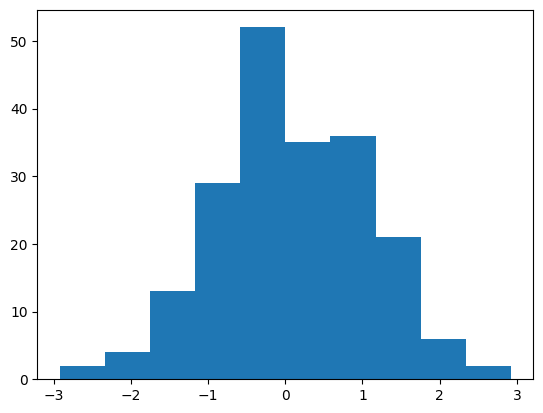

In [46]:
plt.hist(sim.population.phenotypes)

In [55]:
class BreedingEnvironment:
    def __init__(self, sim, model):
        self.sim = sim 
        self.model = model

    def run_one_generation(self):
        state = self.sim.get_state() 
        # Prepare inputs for the model 

        input1 = state['maf'].unsqueeze(0)
        input2 = state['inbreeding_coefficient'].unsqueeze(0) 
        input3 = state['heterozygosity'].unsqueeze(0)
        input4 = state['genotype_frequencies'].unsqueeze(0)
        input_matrix = state['ld_matrix'].unsqueeze(0)

        # Get action probabilities from the model
        action_probs = self.model(input1, input2, input3, input4, input_matrix)
        return action_probs

In [56]:
n_chr = 1
n_loci = 1000
founder_pop_size = 200

G = Genome(n_chr, n_loci)
founder_pop = create_pop(G, create_random_pop(G, founder_pop_size))
T = Trait(G, founder_pop, target_mean=0.0, target_variance=1.0)

sim = BreedingSimulation(G, T, h2
                         =0.2, reps=2, pop_size=founder_pop_size, selection_fraction=0.5)

model = MyNetwork(n_loci, founder_pop_size)


# Example usage for a single cycle in an episode.

#grab the networks inputs from this function
pop_stat_in  = sim.population.haplotypes.sum(dim=1).view((sim.population.size, n_chr* n_loci)).float()
pop_stat = population_statistics(pop_stat_in)

input1 = pop_stat['maf'].unsqueeze(0)
input2 = pop_stat['inbreeding_coefficient'].unsqueeze(0) 
input3 = pop_stat['heterozygosity'].unsqueeze(0)
input4 = pop_stat['genotype_frequencies'][1].unsqueeze(0)
input_matrix = pop_stat['ld_matrix'].unsqueeze(0)
output = model(input1, input2, input3, input4, input_matrix)
#torch.Size([1, 2, 5]) 2 choices, 5 options, probabiltiies
print(output.shape)

torch.Size([1, 2, 5])


In [57]:
model(input1, input2, input3, input4, input_matrix)

tensor([[[0.1921, 0.1929, 0.2199, 0.1961, 0.1990],
         [0.1875, 0.1883, 0.2303, 0.1794, 0.2145]]],
       grad_fn=<SoftmaxBackward0>)

In [58]:
BE = BreedingEnvironment(sim,model)

In [59]:
state = BE.sim.get_state() 

# Prepare inputs for the model 
input1 = state['maf'].unsqueeze(0)
input2 = state['inbreeding_coefficient'].unsqueeze(0) 
input3 = state['heterozygosity'].unsqueeze(0)
input4 = state['genotype_frequencies'].unsqueeze(0)
input_matrix = state['ld_matrix'].unsqueeze(0)

In [60]:
input3

tensor([[0.4600, 0.5850, 0.4650, 0.4900, 0.5150, 0.5050, 0.4850, 0.5750, 0.5050,
         0.5250, 0.4850, 0.5200, 0.5100, 0.5100, 0.5200, 0.4900, 0.5200, 0.4650,
         0.4950, 0.5450, 0.5500, 0.4700, 0.4300, 0.5000, 0.5650, 0.5150, 0.5000,
         0.5150, 0.4550, 0.5200, 0.5400, 0.5050, 0.4800, 0.4250, 0.4650, 0.4750,
         0.5350, 0.5300, 0.5600, 0.5050, 0.5150, 0.5150, 0.4800, 0.5400, 0.5200,
         0.4450, 0.5350, 0.4850, 0.4900, 0.4900, 0.4900, 0.5250, 0.5050, 0.4900,
         0.5300, 0.4800, 0.5250, 0.4700, 0.5550, 0.4950, 0.4500, 0.5150, 0.5300,
         0.4800, 0.4950, 0.4650, 0.5000, 0.4800, 0.4100, 0.4750, 0.4300, 0.4950,
         0.5150, 0.5050, 0.4900, 0.5100, 0.5050, 0.5100, 0.5350, 0.4800, 0.5200,
         0.4900, 0.5200, 0.4650, 0.4750, 0.5350, 0.4600, 0.5250, 0.4900, 0.5100,
         0.4700, 0.4850, 0.4600, 0.5050, 0.4300, 0.4950, 0.5000, 0.4850, 0.5100,
         0.5100, 0.5200, 0.4800, 0.5650, 0.4300, 0.4700, 0.5300, 0.5550, 0.4950,
         0.6000, 0.5200, 0.4

In [61]:
output = model(input1, input2, input3, input4, input_matrix)
#torch.Size([1, 2, 5]) 2 choices, 5 options, probabiltiies
print(output.shape)

torch.Size([1, 2, 5])


In [62]:
BE.run_one_generation()

tensor([[[0.1921, 0.1929, 0.2199, 0.1961, 0.1990],
         [0.1875, 0.1883, 0.2303, 0.1794, 0.2145]]],
       grad_fn=<SoftmaxBackward0>)